# Cryptocurrency price prediction using LSTM

In [3]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline
import pickle

In [4]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [5]:
hist.head(10)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2020-07-17,9183.08,9080.61,9133.23,20542.60,1.877101e+08,9156.79,direct,
2020-07-18,9205.94,9125.92,9156.79,11952.82,1.095633e+08,9177.22,direct,
2020-07-19,9238.30,9113.41,9177.22,12797.83,1.172980e+08,9216.02,direct,
2020-07-20,9224.76,9136.90,9216.02,18729.90,1.718770e+08,9164.42,direct,
2020-07-21,9435.55,9162.25,9164.42,34505.35,3.376457e+08,9392.83,direct,
2020-07-22,9551.87,9289.85,9392.83,29959.04,2.816611e+08,9537.24,direct,
2020-07-23,9675.50,9458.25,9537.24,43462.72,4.150799e+08,9615.21,direct,
2020-07-24,9647.83,9477.19,9615.21,33810.92,3.230925e+08,9550.23,direct,
2020-07-25,9744.72,9536.76,9550.23,24211.00,2.333010e+08,9708.41,direct,


In [6]:
len(hist)

501

In [7]:
hist.tail()

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2021-11-25,59437.04,57056.64,57175.09,24221.47,1.412787e+09,58966.99,direct,
2021-11-26,59201.95,53575.54,58966.99,60064.72,3.312563e+09,53788.22,direct,
2021-11-27,55316.65,53668.95,53788.22,18504.73,1.010586e+09,54805.03,direct,
2021-11-28,57475.26,53436.05,54805.03,21562.34,1.186995e+09,57331.41,direct,
2021-11-29,58898.57,56752.37,57331.41,24482.75,1.410547e+09,58379.92,direct,


In [8]:
hist = hist.drop(['conversionType', 'conversionSymbol'], axis = 1)

In [9]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(hist, test_size=0.2)

In [10]:
print(train)

                high       low      open  volumefrom      volumeto     close
time                                                                        
2020-07-17   9183.08   9080.61   9133.23    20542.60  1.877101e+08   9156.79
2020-07-18   9205.94   9125.92   9156.79    11952.82  1.095633e+08   9177.22
2020-07-19   9238.30   9113.41   9177.22    12797.83  1.172980e+08   9216.02
2020-07-20   9224.76   9136.90   9216.02    18729.90  1.718770e+08   9164.42
2020-07-21   9435.55   9162.25   9164.42    34505.35  3.376457e+08   9392.83
...              ...       ...       ...         ...           ...       ...
2021-08-17  47100.97  44438.79  45927.40    37125.87  1.700658e+09  44684.43
2021-08-18  46024.97  44240.90  44684.43    30513.78  1.377529e+09  44714.54
2021-08-19  47044.06  43982.21  44714.54    33300.50  1.511028e+09  46761.49
2021-08-20  49377.50  46652.00  46761.49    36326.20  1.742574e+09  49336.45
2021-08-21  49809.82  48330.03  49336.45    22928.52  1.125509e+09  48867.87

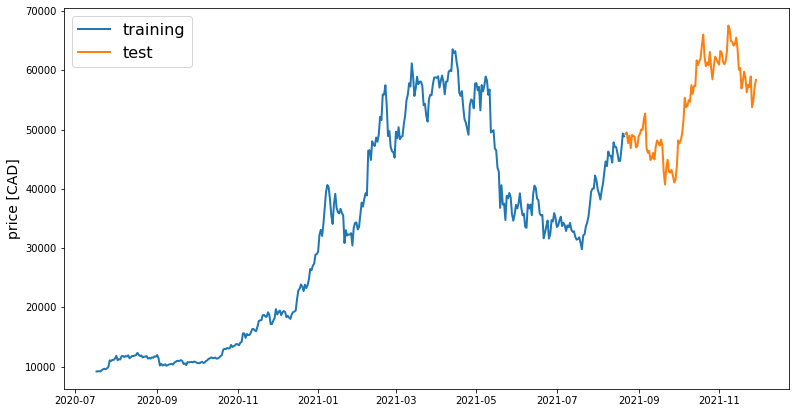

In [11]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [12]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [13]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [14]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [15]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [16]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [17]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 2s 6ms/step - loss: 0.0091
Epoch 2/20
13/13 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 3/20
13/13 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 4/20
13/13 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 5/20
13/13 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 6/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 7/20
13/13 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 8/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 9/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 10/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 11/20
13/13 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 12/20
13/13 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 13/20
13/13 [==============================

In [18]:
# save the model to disk
filename = 'finalized_LSTM_model.sav'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://d19ac1bc-5560-4304-90cb-fa1b7b8c97dd/assets


INFO:tensorflow:Assets written to: ram://d19ac1bc-5560-4304-90cb-fa1b7b8c97dd/assets


In [19]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mae = mean_absolute_error(preds, y_test)
print("Mean absolute  error : ", mae)

Mean absolute  error :  0.03139032561327207


In [20]:
from sklearn.metrics import mean_absolute_percentage_error

targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mape = mean_absolute_percentage_error(preds, y_test)
print("Mean absolute percentage error : ", mape)

Mean absolute percentage error :  4.146599367199118


In [21]:
from sklearn.metrics import r2_score

preds = model.predict(X_test).squeeze()
r2 = r2_score(y_test, preds)
print("R2 error", r2)

R2 error 0.6698739028508626


In [22]:
from sklearn.metrics import mean_squared_error
import math

preds = model.predict(X_test).squeeze()
mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
print("Mean Squered Error :", mse)
print("Root Mean Squered Error :",rmse)

Mean Squered Error : 0.0017272997541752674
Root Mean Squered Error : 0.041560795879954794


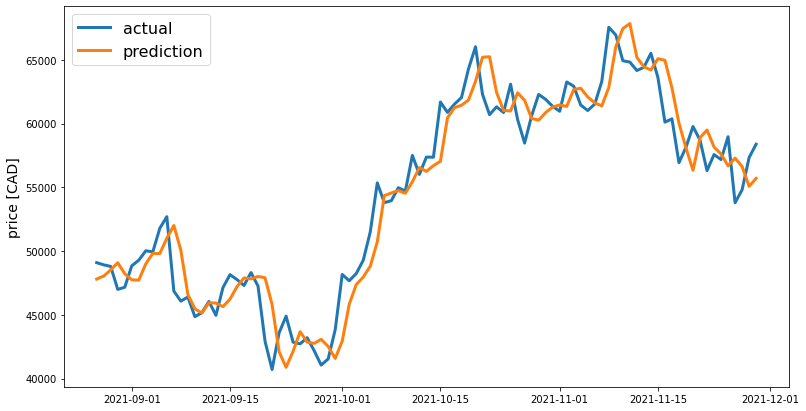

In [23]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)